**Rozdział 9. Uczenie nienadzorowane**

_Notatnik ten zawiera przykładowy kod i rozwiązania ćwiczeń opisane w rozdziale 9._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Uruchom w Google Colab (wersja angielska)</a>
  </td>
</table>

# Konfiguracja

Importujmy najpierw kilka popularnych modułów, upewnijmy się, że będą wstawiane wykresy MatplotLib, a także przygotujmy funkcję zapisującą rysunki. Sprawdzimy także, czy jest zainstalowane środowisko Python 3.5 lub nowsze (możliwe, że kod będzie działał w środowisku Python 2.x, zostało ono jednak porzucone, dlatego zalecamy korzystanie ze środowiska Python 3), a także biblioteka Scikit-Learn 0.20 lub nowsza.

In [1]:
# Wymagane środowisko Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

# Wymagana biblioteka Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Importuje standardowe biblioteki
import numpy as np
import os

# Aby wyniki uzyskiwane w tym notatniku były odtwarzalne
np.random.seed(42)

# Do rysowania ładnych wykresów
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ścieżka zapisywania rysunków
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "R09"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "rysunki", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Zapisywanie rysunku", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignoruje niepotrzebne ostrzeżenia (sprawdź problem numer 5998 SciPy)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Analiza skupień

## Wprowadzenie – klasyfikacja a analiza skupień

In [2]:
from sklearn.datasets import load_iris

In [3]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Zapisywanie rysunku r_9_1


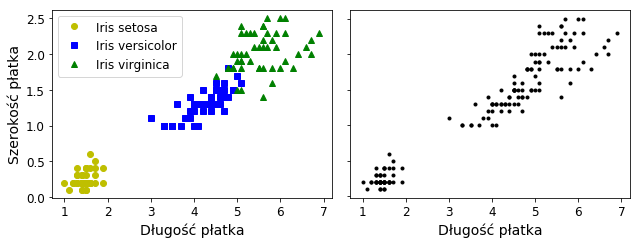

In [4]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Długość płatka", fontsize=14)
plt.ylabel("Szerokość płatka", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Długość płatka", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("r_9_1")
plt.show()

Model mieszanin gaussowskich (opisany poniżej) istotnie jest w stanie całkiem skutecznie rozdzielić te skupienia (za pomocą wszystkich czterech cech: długości i szerokości płatka oraz długości i szerokości działki kielicha).

In [5]:
from sklearn.mixture import GaussianMixture

In [6]:
y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)
mapping = np.array([2, 0, 1])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

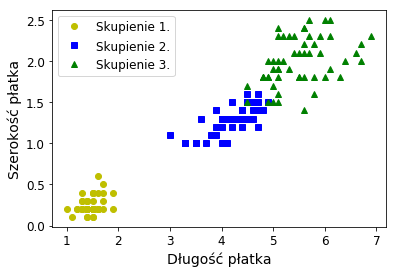

In [7]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Skupienie 1.")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Skupienie 2.")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Skupienie 3.")
plt.xlabel("Długość płatka", fontsize=14)
plt.ylabel("Szerokość płatka", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [8]:
np.sum(y_pred==y)

145

In [9]:
np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

## Algorytm centroidów

Zacznijmy od wygenerowania kleksów:

In [10]:
from sklearn.datasets import make_blobs

In [11]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [12]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Stwórzmy teraz ich wykres:

In [13]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Zapisywanie rysunku r_9_2


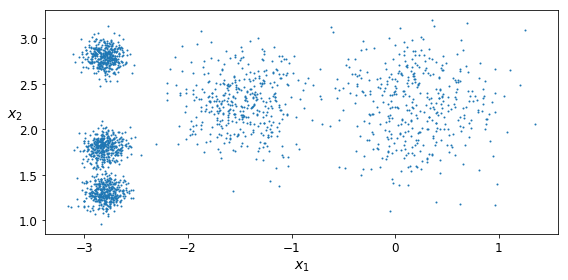

In [14]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("r_9_2")
plt.show()

### Dopasowywanie i prognozowanie

Wyuczmy za pomocą tego zbioru algorytm centroidów. Będzie starał się on wyszukiwać środek każdego kleksa i przydzielać poszczególne przykłady do najbliższego skupienia:

In [15]:
from sklearn.cluster import KMeans

In [16]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Każdy przykład został przydzielony do jednego z pięciu skupień:

In [17]:
y_pred

array([4, 0, 1, ..., 2, 1, 0])

In [18]:
y_pred is kmeans.labels_

True

Zostało oszacowanych pięć _centroidów_ (czyli środków skupień):

In [19]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

Zwróć uwagę, że instancja `KMeans` przechowuje etykiety przykładów, na których była trenowana. Jest zatem dość dziwne w tym kontekście, że _etykietą_ przykładu jest indeks skupienia, do którego ten przykład został przypisany:

In [20]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0])

Możemy, oczywiście, prognozować etykiety nowych przykładów:

In [21]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2])

### Granice decyzyjne

Stwórzmy wykres granic decyzyjnych modelu. Otrzymamy w ten sposób _diagram Woronoja_:

In [22]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Zapisywanie rysunku r_9_3


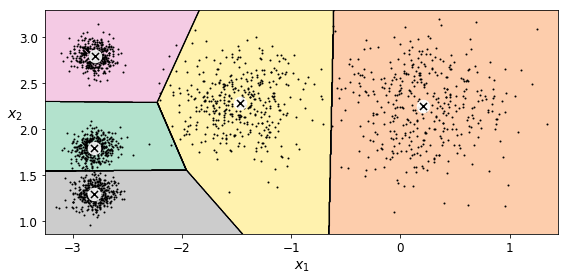

In [23]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("r_9_3")
plt.show()

Nieźle! Niektóre przykłady w pobliżu krańców prawdopodobnie zostały przypisane do niewłaściwego skupienia, ale zasadniczo wygląda to całkiem dobrze.

### Twarda i miękka analiza skupień

Zamiast dowolnie wybierać najbliższe skupienie dla każdego przykładu (_twarda analiza skupień_), czasami lepiej jest zmierzyć odległość przykładu do każdego z pięciu centroidów. Odpowiedzialna jest za to metoda `transform()`:

In [24]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

Możesz sprawdzić, że w istocie obliczana jest odległość euklidesowa pomiędzy przykładem a każdym centroidem:

In [25]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

### Algorytm centroidów

Algorytm centroidów jest jednym z najszybszych, a jednocześnie najprostszych algorytmów analizy skupień:
* Najpierw losowo inicjalizujemy $k$ centroidów: zostaje losowo wybranych $k$ różnych przykładów z zestawu danych i na ich miejsce są wstawiane centroidy.
* Proces ten jest powtarzany aż do uzyskania zbieżności (tj. do momentu, aż centroidy nie będą już przesuwane):
    * Przydzielamy wszystkie przykłady do najbliższych centroidów.
    * Aktualizujemy centroidy tak, aby stanowiły one średnią z przypisanych do nich przykładów.

Klasa `KMeans` domyślnie wykorzystuje zoptymalizowaną wersję algorytmu. Aby móc użyć pierwotnego algorytmu centroidów (jedynie w celach dydaktycznych), musisz wyznaczyć `init="random"`, `n_init=1` i `algorithm="full"`. Znaczenie tych hiperparametrów zostanie wyjaśnione poniżej.

Sprawdźmy wyniki algorytmu centroidów uruchomionego na 1, 2 i 3 iteracje i zobaczmy, w jaki sposób przemieszczają się centroidy:

In [26]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=3, n_clusters=5,
       n_init=1, n_jobs=None, precompute_distances='auto', random_state=1,
       tol=0.0001, verbose=0)

I stwórzmy wykres rezultatów:

Zapisywanie rysunku r_9_4


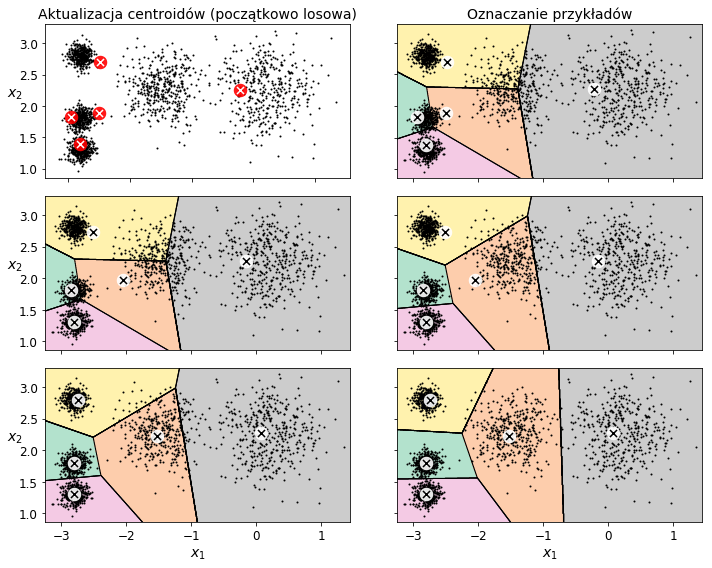

In [27]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Aktualizacja centroidów (początkowo losowa)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Oznaczanie przykładów", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("r_9_4")
plt.show()

### Zmienność w algorytmie centroidów

W pierwotnym algorytmie centroidów są one inicjalizowane losowo i, jak mogliśmy się przekonać, algorytm w każdej iteracji stopniowo znajduje lepsze położenia centroidów.

Jednak olbrzymim problemem tego rozwiązania jest fakt, że jeśli uruchomisz wiele przebiegów algorytmu centroidów (lub użyjesz różnych ziaren losowości), uzyskasz zupełnie różne rozwiązania, o czym możesz przekonać się poniżej:

In [28]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Zapisywanie rysunku r_9_5


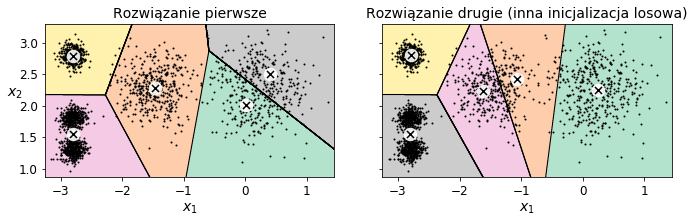

In [29]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Rozwiązanie pierwsze", "Rozwiązanie drugie (inna inicjalizacja losowa)")

save_fig("r_9_5")
plt.show()

### Bezwładność

Aby móc wybrać najlepszy model, będziemy musieli znaleźć sposób określenia wydajności modelu centroidów. Niestety, mamy tu do czynienia z zadaniem uczenia nienadzorowanego, zatem nie dysponujemy zmiennymi docelowymi. Przynajmniej możemy zmierzyć odległość każdego przykładu od jego centroidu. Jest to podstawowe założenie w metryce _bezwładności_:

In [30]:
kmeans.inertia_

211.5985372581684

Można łatwo sprawdzić, że bezwładność stanowi sumę kwadratów odległości pomiędzy każdym przykładem uczącym a najbliższym centroidem:

In [31]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.59853725816856

Metoda `score()` zwraca ujemną wartość bezwładności. Dlaczego ujemną? Wynika to z faktu, że metoda `score()` predyktora musi zawsze przestrzegać reguły "_więcej znaczy lepiej_".

In [32]:
kmeans.score(X)

-211.59853725816856

### Inicjalizacje wielokrotne

Zatem jednym z rozwiązań problemu zmienności jest wielokrotne uruchamianie algorytmu centroidów, za każdym razem z odmienną inicjalizacją losową, i wybieranie rozwiązania minimalizującego bezwładność. Poniżej, na przykład, widzimy bezwładności dwóch "złych" modeli, ukazanych na wcześniejszym rysunku:

In [33]:
kmeans_rnd_init1.inertia_

223.29108572819035

In [34]:
kmeans_rnd_init2.inertia_

237.46249169442845

Jak widać, ich bezwładność jest większa niż w przypadku wyuczonego przez nas "dobrego" modelu, co oznacza, że są one prawdopodobnie gorsze. 

Po wyznaczeniu hiperparametru `n_init` moduł Scikit-Learn realizuje pierwotny algorytm `n_init` razy i wybiera rozwiązanie minimalizujące bezwładność. Domyślną wartością jest `n_init=10`.

In [35]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=300, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=11,
       tol=0.0001, verbose=0)

Jak widać, na koniec otrzymujemy początkowy model, który z pewnością stanowi optymalne rozwiązanie algorytmu centroidów (przynajmniej w kwestii bezwładności i założeniu, że $k=5$).

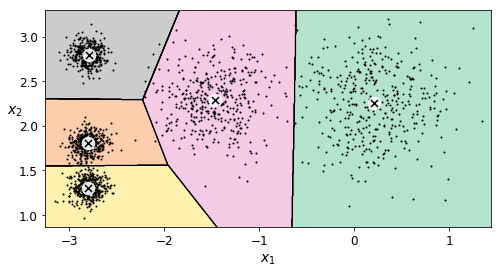

In [36]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### Inicjalizacja K-Means++

Zamiast całkowicie losowego inicjalizowania centroidów, lepiej inicjalizować za pomocą poniższego algorytmu, zaproponowanego w [artykule z 2006 r.](https://goo.gl/eNUPw6) przez Davida Arthura i Sergei'a Vassilvitskii'ego:
* Wybieramy jednostajnie i losowo jeden centroid $c_1$  z zestawu danych.
* Wybieramy nowy środek $c_i$ na podstawie przykładu $\mathbf{x}_i$ z prawdopodobieństwem: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$, gdzie $D(\mathbf{x}_i)$ stanowi odległość pomiędzy przykładem $\mathbf{x}_i$ a najbliższym, już wybranem centroidem. Taki rozkład prawdopodobieństwa gwarantuje, że przykłady znajdujące się daleko od wybranych centroidów mają znacznie większą szansę na bycie wybranymi na centroidy.
* Powtarzamy poprzedni krok aż do momentu wybrania wszystkich $k$ centroidów.

Pozostała część algorytmu K-Means++ jest taka sama, jak standardowy algorytm centroidów. Dzięki takiej formie inicjalizacji algorytm centroidów znacznie rzadziej uzyskuje zbieżność z nieoptymalnym rozwiązaniem, zatem można znacząco zmniejszyć wartość `n_init` W większości przypadku wyrównujemy w ten sposób dodatkową złożoność obliczeniową procesu inicjalizacji.

Aby wyznaczyć inicjalizację K-Means++, wystarczy wprowadzić `init="k-means++"` (w rzeczywistości jest to wartość domyślna):

In [37]:
KMeans()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [38]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.5985372581684

### Przyspieszony algorytm centroidów

Algorytm centroidów można znacznie przyspieszyć, jeżeli pominiemy wiele niepotrzebnych obliczeń odległości: osiągamy to za pomocą nierówności trójkąta (mając dane trzy punkty A, B i C, odległość AC jest zawsze taka, że AC ≤ AB + BC), a także poprzez śledzenie dolnego i górnego przedziału odległości pomiędzy przykładami a centroidami (szczegóły znajdziesz w [artykule z 2003 r.](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) autorstwa Charlesa Elkana).

Aby skorzystać z wariantu Elkana, wystarczy wyznaczyć `algorithm="elkan"`. Należy pamiętać, że algorytm ten nie obsługuje danych rzadkich, dlatego domyślnie moduł Scikit-Learn wykorzystuje wartość `"elkan"` dla danych gęstych, a `"full"` (standardowy algorytm centroidów) dla danych rzadkich.

In [39]:
%timeit -n 50 KMeans(algorithm="elkan").fit(X)

64.9 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [40]:
%timeit -n 50 KMeans(algorithm="full").fit(X)

77.2 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


### Algorytm centroidów z minigrupami

Moduł Scikit-Learn zawiera również implementację algorytmu centroidów obsługującą minigrupy (zobacz [ten artykuł](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)):

In [41]:
from sklearn.cluster import MiniBatchKMeans

In [42]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [43]:
minibatch_kmeans.inertia_

211.93186531476775

Jeżeli zestaw danych nie mieści się w pamięci, najprostszym rozwiązaniem okazuje się użycie klasy `memmap` w taki sam sposób, jak wykorzystaliśmy ją w przyrostowej analizie PCA w poprzednim rozdziale. Wczytajmy najpierw zestaw danych MNIST:

In [44]:
import urllib
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

Prześlijmy je teraz do metody `memmap`:

In [48]:
filename = "my_mnist_data.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

In [49]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

Jeżeli Twoje dane są tak duże, że nie możesz skorzystać z klasy `memmap`, to sprawy zaczynają się komplikować. Zacznijmy od napisania funkcji wczytującej kolejną grupę (w rzeczywistej sytuacji wczytywalibyśmy dane z dysku):

In [50]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

Możemy teraz wytrenować model poprzez dostarczanie mu każdorazowo po jednej grupie. Musimy także zaimplementować inicjalizacje wielokrotne i wybrać model o najmniejszej bezwładności:

In [51]:
np.random.seed(42)

In [52]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # więcej danych dla inicjalizacji K-Means++
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [53]:
best_kmeans.score(X)

-211.70999744411483

Algorytm centroidów z minigrupami jest o wiele szybszy od jego standardowej wersji:

In [54]:
%timeit KMeans(n_clusters=5).fit(X)

33.3 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
%timeit MiniBatchKMeans(n_clusters=5).fit(X)

18.4 ms ± 697 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Jest *o wiele* szybciej! Często jednak wydajność modelu jest gorsza (większa bezwładność) i stopniowo maleje w miarę wzrostu wartości _k_. Stwórzmy wykres współczynnika bezwładności od współczynnika czasu uczenia pomiędzy algorytmem centroidów z minigrupami a jego standardową wersją:

In [56]:
from timeit import timeit

In [57]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))
for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

Zapisywanie rysunku r_9_6


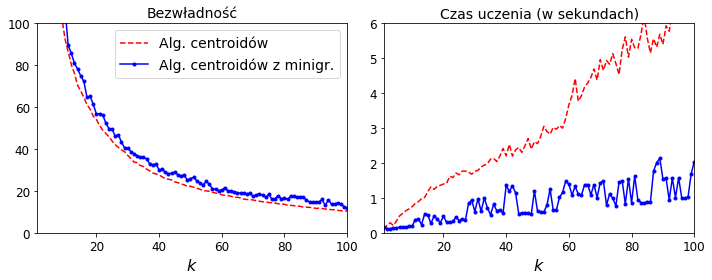

In [58]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], "r--", label="Alg. centroidów")
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Alg. centroidów z minigr.")
plt.xlabel("$k$", fontsize=16)
plt.title("Bezwładność", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label="Alg. centroidów")
plt.plot(range(1, 101), times[:, 1], "b.-", label="Alg. centroidów z minigr.")
plt.xlabel("$k$", fontsize=16)
plt.title("Czas uczenia (w sekundach)", fontsize=14)
plt.axis([1, 100, 0, 6])

save_fig("r_9_6")
plt.show()

### Wyszukiwanie optymalnej liczby skupień

Co się dzieje w przypadku, gdy liczba skupień jest mniejsza lub większa od 5?

Zapisywanie rysunku r_9_7


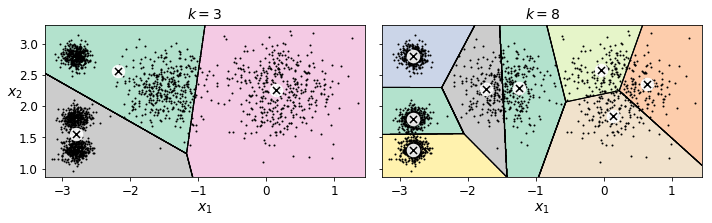

In [59]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("r_9_7")
plt.show()

Auć, te dwa modele nie prezentują się zbyt dobrze. Jak wyglądają ich bezwładności?

In [60]:
kmeans_k3.inertia_

653.2167190021553

In [61]:
kmeans_k8.inertia_

119.11983416102879

Niestety, nie możemy tak po prostu wybrać wartości $k$ minimalizującej bezwładność, ponieważ ta maleje wraz ze wzrostem $k$. Rzeczywiście, im więcej występuje skupień, tym bliżej każdy przykład będzie znajdował się swojego centroidu, a zatem bezwładność będzie również malała. Możemy jednak stworzyć wykres bezwładności jako funkcji $k$ i przeanalizować uzyskaną krzywą:

In [62]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Zapisywanie rysunku r_9_8


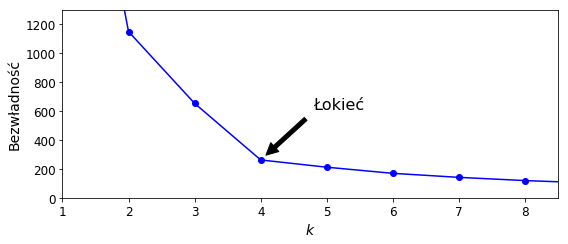

In [63]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Bezwładność", fontsize=14)
plt.annotate('Łokieć',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("r_9_8")
plt.show()

Jak widać, w punkcie znajduje się łokieć (zgięcie) $k=4$, co oznacza, że mniejsza liczba skupień byłaby niewłaściwa, natomiast większa nie pomogłaby zbytnio i być może dobre skupienia zostałyby podzielone na pół. Zatem $k=4$ stanowi całkiem dobry wybór. Oczywiście, w omawianym przykładzie nie jest on doskonały, ponieważ oznacza, że dwa kleksy w lewym dolnym rogu będą uznawane za jedno skupienie, mimo to i tak taki podział jest nienajgorszy.

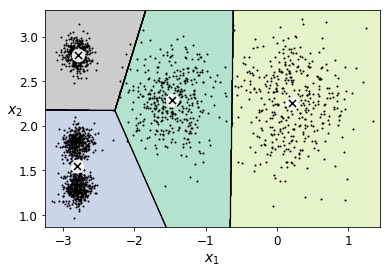

In [64]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

Innym rozwiązaniem jest analiza _wyniku profilu_, czyli średniego _współczynnika profilu_ ze wszystkich przykładów. Współczynnik profilu przykładu jest równy $(b - a)/\max(a, b)$, gdzie $a$ oznacza średnią odległość do pozostałych przykładów w tym samym skupieniu (czyli _średnią odległość wewnątrzskupieniową_), natomiast $b$ definiuje _średnią odległość do najbliższego skupienia_, (minimalizującą $b$, bez uwzględniania skupienia, do którego przynależy dany przykład). Współczynnik profilu mieści się w przedziale pomiędzy -1 a +1: wartość bliska +1 oznacza, że przykład znajduje się głęboko wewnątrz swojego skupienia i daleko od innych skupień, wartość bliska 0 mówi nam, że przykład znajduje się blisko granicy skupienia, natomiast wartość dążąca do -1 oznacza, że przykład mógł zostać przydzielony do niewłaściwego skupienia.

Stwórzmy wykres wyniku profilu jako funkcji $k$:

In [65]:
from sklearn.metrics import silhouette_score

In [66]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [67]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

Zapisywanie rysunku r_9_9


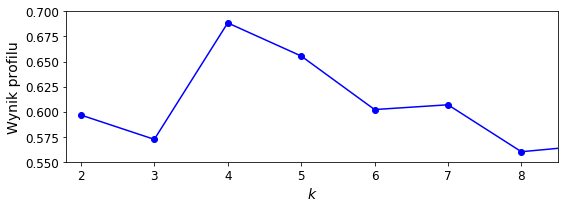

In [68]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Wynik profilu", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("r_9_9")
plt.show()

Jak widać, wykres ten zawiera znacznie więcej informacji od poprzedniego: w szczególności mimo potwierdzenia, że $k=4$ to bardzo dobry wybór, dostarcza dowodu, że również dobry jest $k=5$.

Jeszcze więcej informacji uzyskujemy na wykresie współczynników profilu każdego przykładu, uszeregowanych ze względu na skupienie, do którego przykład został przydzielony, a także uwzględniającym wartość tego współczynnika. Jest to tak zwany _diagram profilu_:

Zapisywanie rysunku r_9_10


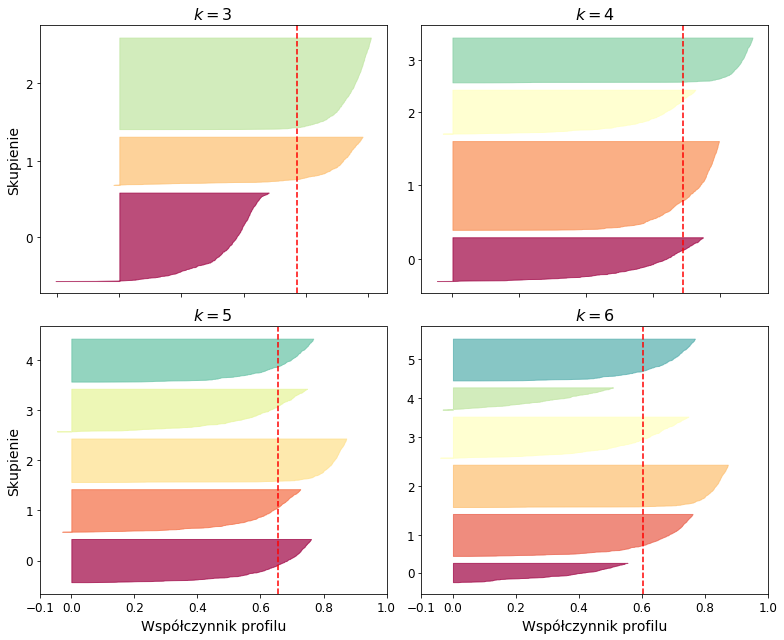

In [69]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Skupienie")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Współczynnik profilu")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("r_9_10")
plt.show()

### Granice algorytmu centroidów

In [70]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

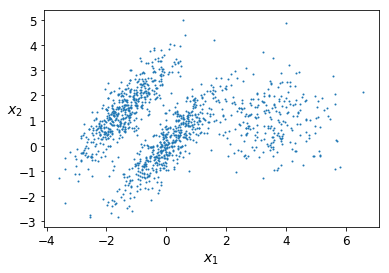

In [71]:
plot_clusters(X)

In [72]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

Zapisywanie rysunku r_9_11


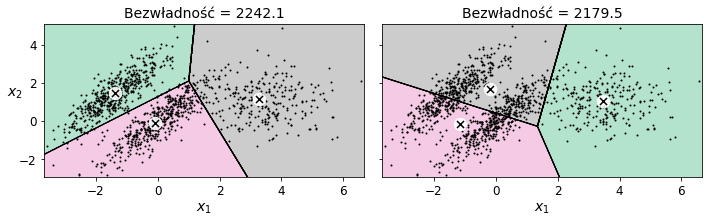

In [73]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Bezwładność = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Bezwładność = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("r_9_11")
plt.show()

### Analiza skupień w segmentacji obrazów

In [74]:
# Pobieranie zdjęcia biedronki
images_path = os.path.join(PROJECT_ROOT_DIR, "rysunki", "R09")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
print("Pobieranie", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

Pobieranie ladybug.png


('.\\rysunki\\R09\\ladybug.png', <http.client.HTTPMessage at 0x29a1c6f7e10>)

In [75]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

In [76]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [77]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

Zapisywanie rysunku r_9_12


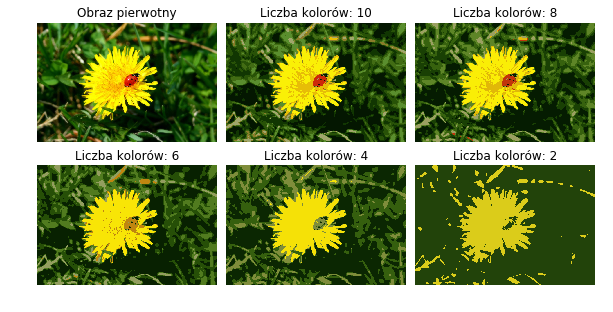

In [78]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Obraz pierwotny")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("Liczba kolorów: {}".format(n_clusters))
    plt.axis('off')

save_fig('r_9_12', tight_layout=False)
plt.show()

### Analiza skupień we wstępnym przetwarzaniu danych

Pobawmy się _zestawem danych Digits_, czyli prostym, podobnym do MNIST zestawem danych zawierającym 1 797 czarno-białych obrazów o rozmiarze 8×8, symbolizujących cyfry od 0 do 9. 

In [79]:
from sklearn.datasets import load_digits

In [80]:
X_digits, y_digits = load_digits(return_X_y=True)

Podzielmy go na zbiory uczący i testowy:

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

Dopasujmy teraz model regresji logistycznej i oceńmy go na zbiorze testowym:

In [83]:
from sklearn.linear_model import LogisticRegression

In [84]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [85]:
log_reg.score(X_test, y_test)

0.9688888888888889

W porządku, dokładność bazowa wynosi 96.89%. Sprawdźmy, czy pomoże nam jakoś algorytm centroidów jako faza przetwarzania wstępnego. Stworzymy potok, który najpierw podzieli dane testowe na 50 skupień i zastąpi obrazy ich odległościami do każdego z tych skupień, po czym zostanie użyty model regresji logistycznej: 

In [86]:
from sklearn.pipeline import Pipeline

In [87]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=50, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=42,
                        tol=0.0001, verbose=0)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=5000,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [88]:
pipeline.score(X_test, y_test)

0.9777777777777777

In [89]:
1 - (1 - 0.977777) / (1 - 0.968888)

0.28570969400874346

Co Ty na to? Zmniejszyliśmy współczynnik błędu o ponad 28%! Wybraliśmy jednak zupełnie dowolnie liczbę skupień $k$ i z pewnością możemy uzyskać jeszcze lepsze wyniki. Skoro algorytm centroidów stanowi jedynie etap przetwarzania wstępnego w potoku klaysfikacji, określenie właściwej wartości $k$ okazuje się znacznie łatwiejsze, niż poprzednio: nie musimy przeprowadzać analizy profilu ani minimalizować bezwładności, a najlepszą wartością $k$ jest po prostu ta, która skutkuje najlepszą wydajnością klasyfikacji.

In [90]:
from sklearn.model_selection import GridSearchCV

In [91]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed: 10.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=50, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=42, tol=0.0001,
                                               verbose=0)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
      

Sprawdźmy liczbę skupień:

In [92]:
grid_clf.best_params_

{'kmeans__n_clusters': 99}

In [93]:
grid_clf.score(X_test, y_test)

0.98

### Analiza skupień w uczeniu półnadzorowanym

Kolejnym przypadkiem zastosowania analizy skupień jest uczenie półnadzorowane, gdy dysponujemy dużą liczbą przykładów nieoznakowanych i niewieloma przykładami oznakowanymi.

Sprawdźmy wydajność modelu regresji logistycznej dla zaledwie 50 przykładów oznakowanych:

In [94]:
n_labeled = 50

In [95]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

Wydajność jest, oczywiście, znacznie gorsza niż poprzednio. Sprawdźmy, jak możemy to zmienić. Najpierw podzielmy dane uczące na 50 skupień, a następnie dla każdego skupienia wyszukajmy obraz znajdujący się najbliżej centroidu. Będą to tak zwane obrazy reprezentatywne:

In [96]:
k = 50

In [97]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Stwórzmy wykres tych obrazów reprezentatywnych i oznaczmy je własnoręcznie:

Zapisywanie rysunku r_9_13


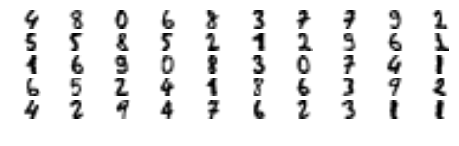

In [98]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("r_9_13", tight_layout=False)
plt.show()

In [99]:
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 9, 6, 1,
    1, 6, 9, 0, 8, 3, 0, 7, 4, 1,
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2,
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

Dysponujemy teraz zestawem danych zawierającym zaledwie 50 przykładów oznakowanych, ale nie są to już całkowicie losowe przykłady, gdyż każdy z nich stanowi obraz reprezentatywny skupienia. Sprawdźmy, czy spowoduje to poprawę wydajności modelu:

In [100]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9222222222222223

Wow! Skoczyliśmy z dokładności 83.3% do wartości 92.2%, mimo że cały czas uczymy model wyłącznie za pomocą 50 przykładów. Proces oznaczania przykładów jest często kosztowny i nieprzyjemny, zwłaszcza gdy muszą go realizować eksperci z danej dziedziny, dlatego całkiem niezłym rozwiązaniem jest wprowadzanie przykładów reprezentatywnych zamiast losowych.

Być może jednak możemy pójść jeszcze dalej: spróbujmy rozprzestrzenić etykiety na wszystkie pozostałe przykłady w tym samym skupieniu.

In [101]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [102]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [103]:
log_reg.score(X_test, y_test)

0.9333333333333333

Dokładność wzrosła nieznacznie. Lepsze to niż nic, ale być może powinniśmy rozprzestrzenić etykiety jedynie na przykłady znajdujące się najbliżej centroidów, ponieważ poprzez propagację na całe skupienie z pewnością oznakowaliśmy również elementy odstające. Oznakujmy 20. percentyl przykładów znajdujących się najbliżej centroidów:

In [104]:
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [105]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [106]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [107]:
log_reg.score(X_test, y_test)

0.94

Ładnie! Za pomocą jedynie 50 przykładów oznakowanych (średnio zaledwie po pięć przykładów na każdą klasę!) uzyskaliśmy wydajność rzędu 94%, co stanowi wynik zbliżony do wydajności modelu regresji logistycznej dla w pełni oznakowanego zestawu danych _digits_ (czyli 96.9%).

Wynika to z faktu, że rozprzestrzenione etykiety są w istocie bardzo dobre: ich dokładność wynosi niemal 99%:

In [108]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9896907216494846

Możesz teraz wykonać kilka iteracji *uczenia aktywnego*:
1. Ręcznie oznacz przykłady, co do których klasyfikator ma największe możliwości, i w miarę potrzeby wybieraj je z różnych skupień.
2. Wytrenuj model za pomocą tych dodatkowych etykiet.

## Algorytm DBSCAN

In [109]:
from sklearn.datasets import make_moons

In [110]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [111]:
from sklearn.cluster import DBSCAN

In [112]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [113]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5], dtype=int64)

In [114]:
len(dbscan.core_sample_indices_)

808

In [115]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13], dtype=int64)

In [116]:
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

In [117]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

In [118]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [119]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

Zapisywanie rysunku r_9_14


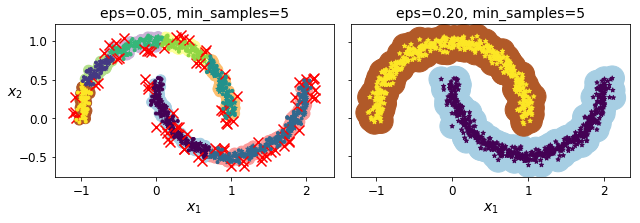

In [120]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("r_9_14")
plt.show()


In [121]:
dbscan = dbscan2

In [122]:
from sklearn.neighbors import KNeighborsClassifier

In [123]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

In [124]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0], dtype=int64)

In [125]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

Zapisywanie rysunku r_9_15


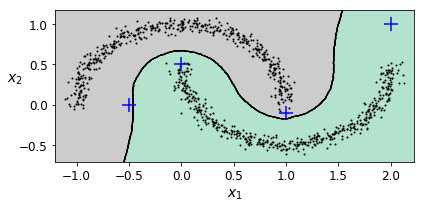

In [126]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("r_9_15")
plt.show()

In [127]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1], dtype=int64)

## Inne algorytmy analizy skupień

### Widmowa analiza skupień

In [128]:
from sklearn.cluster import SpectralClustering

In [129]:
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=100,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=None,
                   n_neighbors=10, random_state=42)

In [130]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1,
                   kernel_params=None, n_clusters=2, n_init=10, n_jobs=None,
                   n_neighbors=10, random_state=42)

In [131]:
np.percentile(sc1.affinity_matrix_, 95)

0.04251990648936265

In [132]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

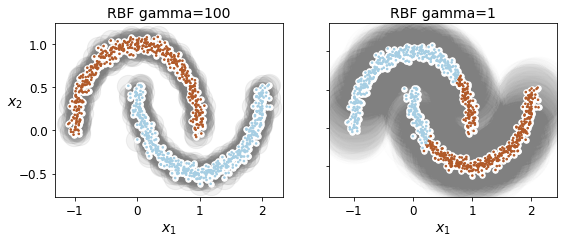

In [133]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()


### Aglomeracyjna analiza skupień

In [134]:
from sklearn.cluster import AgglomerativeClustering

In [135]:
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [136]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

In [137]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_components_',
 'n_connected_components_',
 'n_leaves_']

In [138]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

# Mieszaniny gaussowskie

In [139]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Wyuczmy model mieszaniny gaussowskiej na poprzednim zestawie danych:

In [140]:
from sklearn.mixture import GaussianMixture

In [141]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Przyjrzyjmy się parametrom oszacowanym przez algorytm EM:

In [142]:
gm.weights_

array([0.20965228, 0.4000662 , 0.39028152])

In [143]:
gm.means_

array([[ 3.39909717,  1.05933727],
       [-1.40763984,  1.42710194],
       [ 0.05135313,  0.07524095]])

In [144]:
gm.covariances_

array([[[ 1.14807234, -0.03270354],
        [-0.03270354,  0.95496237]],

       [[ 0.63478101,  0.72969804],
        [ 0.72969804,  1.1609872 ]],

       [[ 0.68809572,  0.79608475],
        [ 0.79608475,  1.21234145]]])

Czy algorytm rzeczywiście uzyskał zbieżność?

In [145]:
gm.converged_

True

Tak, dobrze. Jak wiele iteracji mu to zajęło?

In [146]:
gm.n_iter_

4

Możesz teraz wykorzystać model do przewidywania, do którego skupienia przynależy każdy przykład (twarda analiza skupień) lub uzyskać prawdopodobieństwa przynależności do każdego skupienia. W pierwszym przypadku wystarczy użyć metody `predict()`, a w drugim metody `predict_proba()`:

In [147]:
gm.predict(X)

array([2, 2, 1, ..., 0, 0, 0], dtype=int64)

In [148]:
gm.predict_proba(X)

array([[2.32389467e-02, 6.77397850e-07, 9.76760376e-01],
       [1.64685609e-02, 6.75361303e-04, 9.82856078e-01],
       [2.01535333e-06, 9.99923053e-01, 7.49319577e-05],
       ...,
       [9.99999571e-01, 2.13946075e-26, 4.28788333e-07],
       [1.00000000e+00, 1.46454409e-41, 5.12459171e-16],
       [1.00000000e+00, 8.02006365e-41, 2.27626238e-15]])

Jest to model generatywny, możesz więc uzyskać dzięki niemu nowe przykłady (wraz z etykietami):

In [149]:
X_new, y_new = gm.sample(6)
X_new

array([[ 2.95400315,  2.63680992],
       [-1.16654575,  1.62792705],
       [-1.39477712, -1.48511338],
       [ 0.27221525,  0.690366  ],
       [ 0.54095936,  0.48591934],
       [ 0.38064009, -0.56240465]])

In [150]:
y_new

array([0, 1, 2, 2, 2, 2])

Zwróć uwagę, że są one losowane sekwencyjnie z każdego skupienia.

Możesz także oszacować logarytm _funkcji gęstości prawdopodobieństwa_ (PDF) w dowolnym miejscu za pomocą metody `score_samples()`:

In [151]:
gm.score_samples(X)

array([-2.60782346, -3.57106041, -3.33003479, ..., -3.51352783,
       -4.39802535, -3.80743859])

Sprawdźmy czy całka z funkcji PDF wynosi 1 w całej przestrzeni. Wystarczy objąć skupienia dużym kwadratem i podzielić go na siatkę mniejszych kwadratów, po czym obliczyć przybliżone prawdopodobieństwo wygenerowania przykładów w każdym z tych kwadracików (poprzez pomnożenie funkcji PDF w jednym rogu tego kwadraciku przez powierzchnię kwadratu, a na końcu zsumowanie tych przybliżonych prawdopodobieństw). Wynik jest bardzo zbliżony do 1:

In [152]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999217849

Stwórzmy teraz wykres uzyskanych granic decyzyjnych (linie przerywane) i obrysów gęstości:

In [153]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Zapisywanie rysunku r_9_17


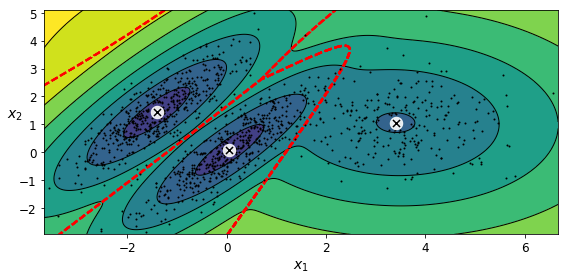

In [154]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("r_9_17")
plt.show()

Możesz nałożyć ograniczenia na macierze kowariancji poprzez wyznaczenie hiperparametru `covariance_type`:
* `"full"` (domyślnie): bez ograniczeń, wszystkie skupienia mogą przybierać dowolny kształt eliptyczny i rozmiar.
* `"tied"`: wszystkie skupienia muszą mieć ten sam rozmiar, ale dowolny kształt eliptyczny (tj. wszystkie współdzielą tę samą macierz kowariancji).
* `"spherical"`: wszystkie skupienia muszą być sferyczne, ale mogą różnić się średnicami (czyli wariancjami).
* `"diag"`: skupienia mogą przyjmować dowolny kształt eliptyczny o dowolnym rozmiarze, ale osie elips muszą być równoległe do osi układu współrzędnych (macierze kowariancji muszą być diagonalne).

In [155]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [156]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


Zapisywanie rysunku r_9_18


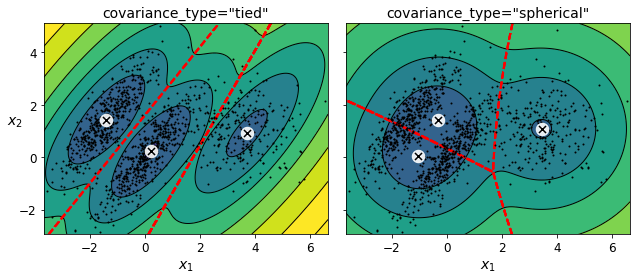

In [157]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

save_fig("r_9_18")
plt.show()

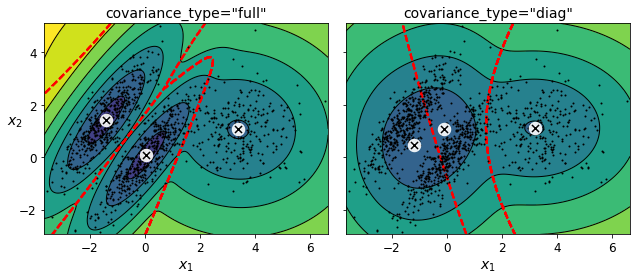

In [158]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

## Wykrywanie anomalii za pomocą mieszanin gaussowskich

Mieszanin gaussowskich można używać do _wykrywania anomalii_: przykłady znajdujące się w obszarach o małej gęstości mogą być traktowane jako anomalie. Należy zdefiniować wykorzystywaną gęstość progową. Na przykład w jakiejś fabryce próbującej wykrywać wadliwe produkty, współczynnik usterek jest zazwyczaj dobrze znany. Załóżmy, że wynosi on 4%, co oznacza, że gęstość progowa będzie miała wartość skutkującą występowaniem 4% przykładów w obszarach o niższej gęstości:

In [159]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

Zapisywanie rysunku r_9_19


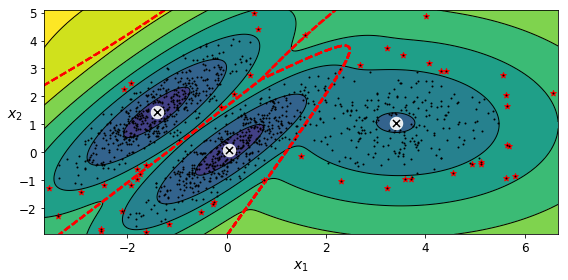

In [160]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

save_fig("r_9_19")
plt.show()

## Wybór modelu

Nie możemy skorzystać z bezwładności ani wyniku profilu, ponieważ w obydwu przypadkach zakładamy, że skupienia są sferyczne. Zamiast tego możemy znaleźć model minimalizujący kryterium informacji teoretycznej, takie jak bayesowskie kryterium informacyjne (BIC) albo kryterium informacji Akaikego (AIC):

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $m$ jest liczbą przykładów.
* $p$ stanowi liczbę parametrów poznanych przez model.
* $\hat L$ określa wartość maksymalną funkcji wiarygodności modelu. Jest to prawdopodobieństwo warunkowe zaobserwowanych danych $\mathbf{X}$ dla danego modelu i jego zoptymalizowanych parametrów.

Zarówno kryterium BIC, jak i AIC karzą modele mające więcej parametrów do wyuczenia (np. więcej skupień), a nagradzają modele dobrze dopasowujące się do danych (czyli modele uzyskujące dużą wiarygodność dla obserwowanych danych).

In [161]:
gm.bic(X)

8189.74345832983

In [162]:
gm.aic(X)

8102.518178214792

Moglibyśmy obliczyć kryterium BIC ręcznie w następujący sposób:

In [163]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [164]:
bic, aic

(8189.74345832983, 8102.518178214792)

In [165]:
n_params

17

Występuje po jednej wadze na każde skupienie, ale ich suma musi być równa 1, dlatego mamy o jeden stopień swobody mniej, stąd -1. W podobny sposób stopnie swobody dla macierzy kowariancji $n \times n$ są równe nie $n^2$, lecz $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$.

Wytrenujmy modele mieszanin gaussowskich z różnymi wartościami $k$ i zmierzmy ich kryterium BIC:

In [166]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [167]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

Zapisywanie rysunku r_9_21


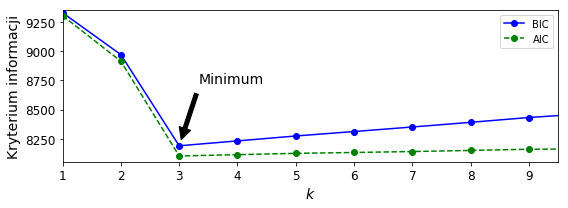

In [168]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Kryterium informacji", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
save_fig("r_9_21")
plt.show()

Wyszukajmy najlepszą kombinację wartości, zarówno pod względem liczby skupień, jak i hiperparametru `covariance_type`:

In [169]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [170]:
best_k

3

In [171]:
best_covariance_type

'full'

## Wariacyjne modele mieszanin gaussowskich

Zamiast własnoręcznie wyszukiwać optymalną liczbę skupień możemy skorzystać z klasy `BayesianGaussianMixture`, które może nadawać niepotrzebnym skupieniom wagi równe (lub zbliżone) 0. Wystarczy wyznaczyć wartość składowych większą od oczekiwanej optymalnej liczby skupień, a algorytm automatycznie wyeliminuje niepotrzebne skupienia.

In [172]:
from sklearn.mixture import BayesianGaussianMixture

In [173]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

Algorytm wykrył automatycznie, że potrzebne są wyłącznie trzy składowe:

In [174]:
np.round(bgm.weights_, 2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

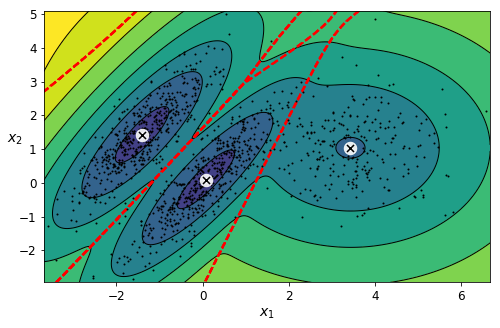

In [175]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [176]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=1000, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=1,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=10000,
                        weight_concentration_prior_type='dirichlet_process')

In [177]:
np.round(bgm_low.weights_, 2)

array([0.52, 0.48, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [178]:
np.round(bgm_high.weights_, 2)

array([0.01, 0.18, 0.27, 0.11, 0.01, 0.01, 0.01, 0.01, 0.37, 0.01])

Zapisywanie rysunku r_9_23


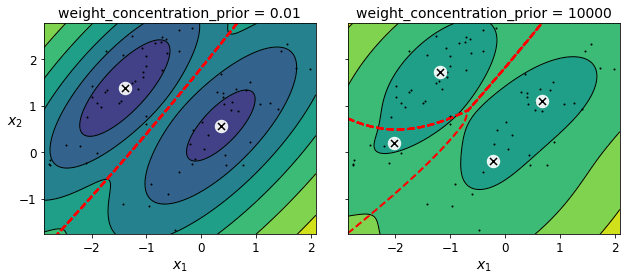

In [179]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

save_fig("r_9_23")
plt.show()

Uwaga: to, że na prawym wykresie widzisz trzy obszary, chociaż występują cztery centroidy, nie jest usterką. Waga skupienia znajdującego się w prawej górnej części wykresu jest znacznie większa od wagi skupienia umieszczonego w prawej dolnej części ekranu, zatem prawdopodobieństwo, że dowolny punkt z tego rejonu stanowi składnik większego skupienia jest o wiele większe od prawdopodobieństwa jego przynależności do skupienia mniejszego.

In [180]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [181]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=10, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

Zapisywanie rysunku r_9_24


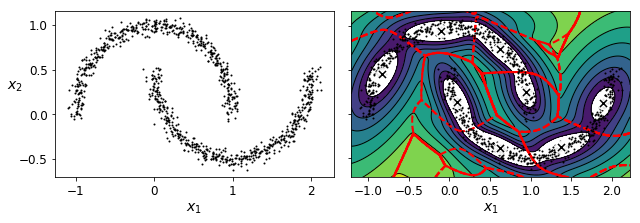

In [182]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

save_fig("r_9_24")
plt.show()

Ups, nie za dobrze... Algorytm powinien wykryć dwa sierpowate skupienia, a rozpoznał osiem skupień eliptycznych. Jednak wykres gęstości nie wygląda źle, można więc go wykorzystać do wykrywania anomalii.

## Funkcja wiarygodności

In [183]:
from scipy.stats import norm

In [184]:
xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)
ZZ = ZZ / ZZ.sum(axis=1)[:,np.newaxis] / (xx[1] - xx[0])

Zapisywanie rysunku r_9_20


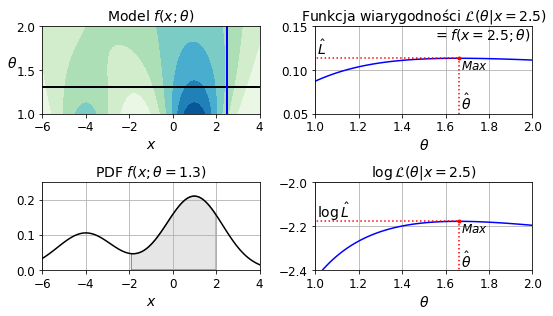

In [185]:
from matplotlib.patches import Polygon

plt.figure(figsize=(8, 4.5))

x_idx = 85
s_idx = 30

plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)

plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.text(1.01, max_val + 0.005, r"$\hat{L}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r"Funkcja wiarygodności $\mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.text(ss[max_idx]+ 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(1.01, max_val + 0.02, r"$\log \, \hat{L}$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)

save_fig("r_9_20")
plt.show()

# Rozwiązania ćwiczeń

## 1. do 9.

Zobacz dodatek A.

## 10. Analiza skupień na zestawie danych Olivetti Faces

*Ćwiczenie: Klasyczny zestaw danych Olivetti zawiera 400 czarnobiałych zdjęć twarzy o rozmiarach 64×64. Każdy obraz został spłaszczony do jednowymiarowego wektora o rozmiarze 4 096. Sfotografowano dziesięć różnych osób (każdą dziesięć razy) i tradycyjnym zadaniem jest wyuczenie modelu tak, aby rozpoznawał osobę widoczną na prezentowanym zdjęciu. Wczytaj omawiany zestaw danych za pomocą funkcji `sklearn.datasets.fetch_olivetti_faces()`.*

In [186]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\Krzysztof\scikit_learn_data


In [187]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [188]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

*Ćwiczenie: Następnie podziel go na zbiory uczący, walidacyjny i testowy (zwróć uwagę, że zestaw ten jest już przeskalowany w zakresie od 0 do 1). Zestaw danych jest dość mały, dlatego prawdopodobnie będziesz chciał użyć losowania warstwowego, aby zapewnić występowanie takiej samej liczby zdjęć każdej osoby we wszystkich podzbiorach danych.*

In [189]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [190]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


Aby przyspieszyć działanie, zmniejszymy wymiarowość danych za pomocą analizy PCA:

In [191]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

*Ćwiczenie: Następnie przeprowadź analizę skupień za pomocą algorytmu centroidów tak, aby uzyskać odpowiednią liczbę skupień (za pomocą jednej z technik omówionych w tym rozdziale). *

In [192]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


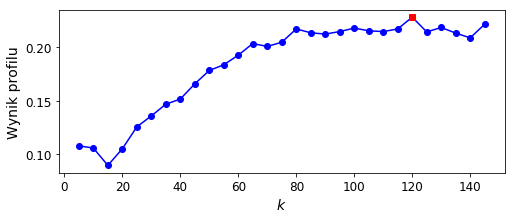

In [193]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Wynik profilu", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [194]:
best_k

120

Wygląda na to, że optymalna liczba skupień jest dość duża, gdyż aż 120. Być może oczekiwałeś, że będzie ona bardziej zbliżona do 40, gdyż zestaw danych zawiera zdjęcia 40 różnych osób. Pamiętaj jednak, że ta sama osob wygląda inaczej na różnych zdjęciach (w okularach/bez okularów, albo po prostu przesunięta w lewo lub w prawo).

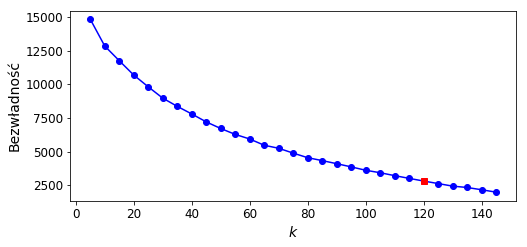

In [195]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Bezwładność", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

Nie można na tym wykresie dokładnie określić optymalnej liczby skupień, gdyż nie widać wyraźnie zarysowanego łokcia, dlatego pozostańmy przy wartości k=120.

In [196]:
best_model = kmeans_per_k[best_index]

*Ćwiczenie: Stwórz wizualizację skupień: czy każde skupienie zawiera podobne twarze?*

Numer skupienia 0


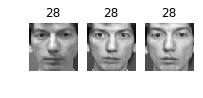

Numer skupienia 1


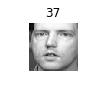

Numer skupienia 2


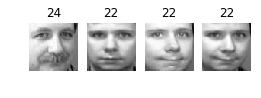

Numer skupienia 3


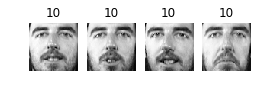

Numer skupienia 4


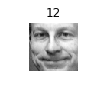

Numer skupienia 5


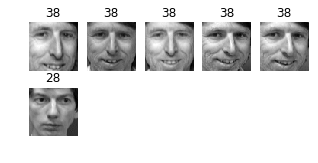

Numer skupienia 6


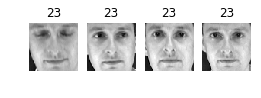

Numer skupienia 7


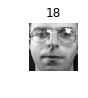

Numer skupienia 8


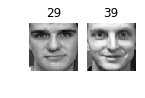

Numer skupienia 9


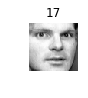

Numer skupienia 10


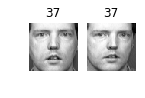

Numer skupienia 11


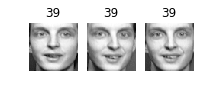

Numer skupienia 12


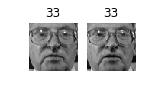

Numer skupienia 13


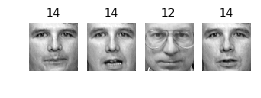

Numer skupienia 14


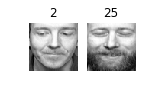

Numer skupienia 15


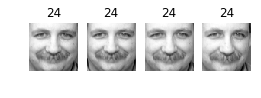

Numer skupienia 16


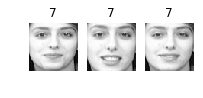

Numer skupienia 17


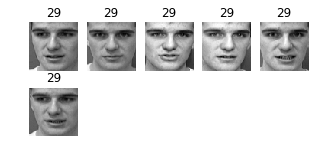

Numer skupienia 18


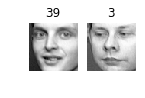

Numer skupienia 19


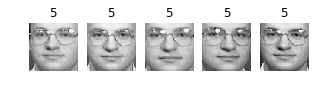

Numer skupienia 20


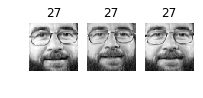

Numer skupienia 21


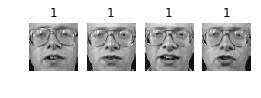

Numer skupienia 22


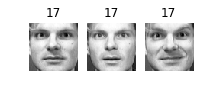

Numer skupienia 23


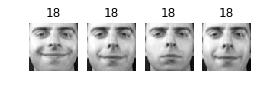

Numer skupienia 24


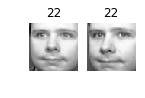

Numer skupienia 25


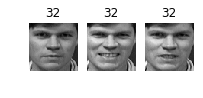

Numer skupienia 26


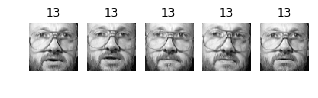

Numer skupienia 27


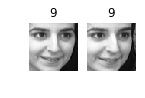

Numer skupienia 28


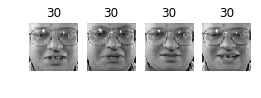

Numer skupienia 29


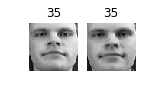

Numer skupienia 30


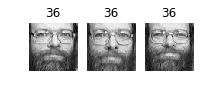

Numer skupienia 31


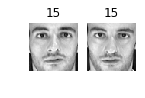

Numer skupienia 32


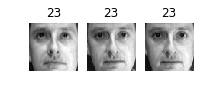

Numer skupienia 33


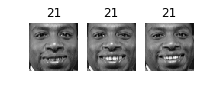

Numer skupienia 34


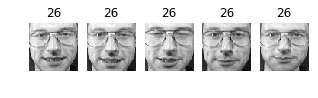

Numer skupienia 35


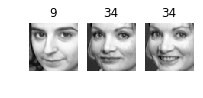

Numer skupienia 36


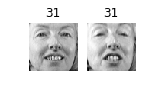

Numer skupienia 37


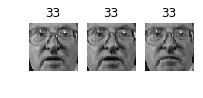

Numer skupienia 38


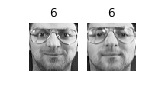

Numer skupienia 39


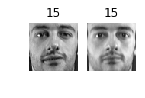

Numer skupienia 40


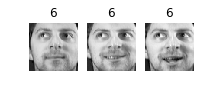

Numer skupienia 41


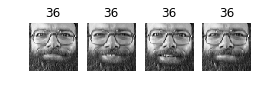

Numer skupienia 42


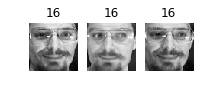

Numer skupienia 43


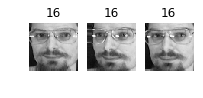

Numer skupienia 44


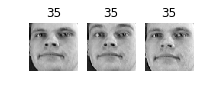

Numer skupienia 45


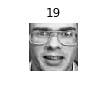

Numer skupienia 46


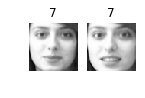

Numer skupienia 47


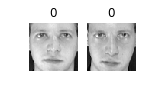

Numer skupienia 48


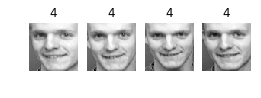

Numer skupienia 49


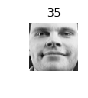

Numer skupienia 50


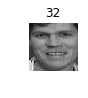

Numer skupienia 51


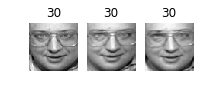

Numer skupienia 52


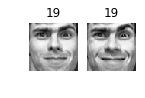

Numer skupienia 53


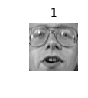

Numer skupienia 54


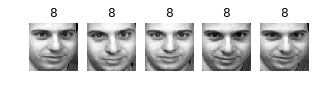

Numer skupienia 55


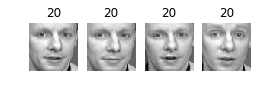

Numer skupienia 56


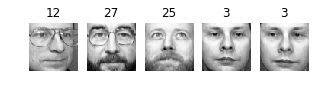

Numer skupienia 57


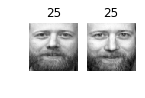

Numer skupienia 58


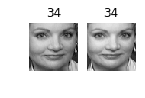

Numer skupienia 59


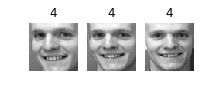

Numer skupienia 60


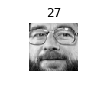

Numer skupienia 61


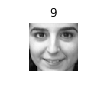

Numer skupienia 62


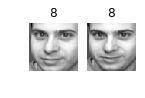

Numer skupienia 63


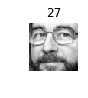

Numer skupienia 64


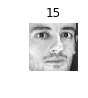

Numer skupienia 65


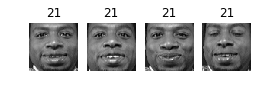

Numer skupienia 66


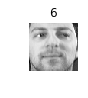

Numer skupienia 67


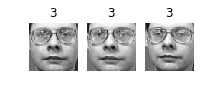

Numer skupienia 68


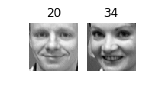

Numer skupienia 69


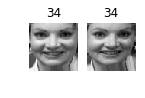

Numer skupienia 70


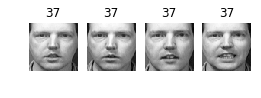

Numer skupienia 71


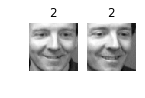

Numer skupienia 72


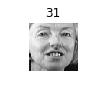

Numer skupienia 73


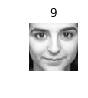

Numer skupienia 74


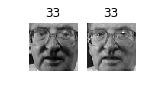

Numer skupienia 75


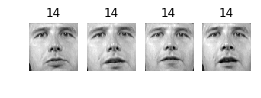

Numer skupienia 76


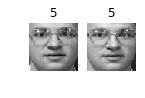

Numer skupienia 77


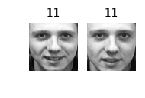

Numer skupienia 78


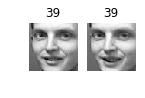

Numer skupienia 79


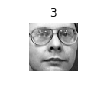

Numer skupienia 80


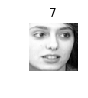

Numer skupienia 81


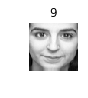

Numer skupienia 82


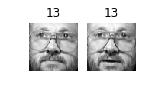

Numer skupienia 83


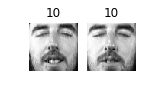

Numer skupienia 84


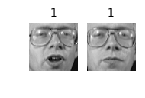

Numer skupienia 85


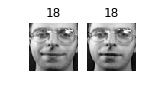

Numer skupienia 86


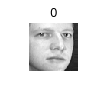

Numer skupienia 87


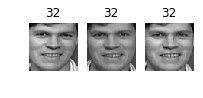

Numer skupienia 88


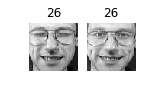

Numer skupienia 89


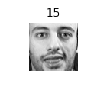

Numer skupienia 90


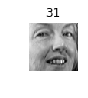

Numer skupienia 91


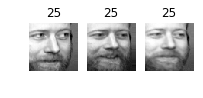

Numer skupienia 92


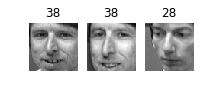

Numer skupienia 93


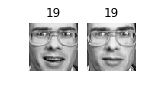

Numer skupienia 94


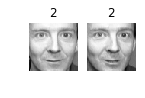

Numer skupienia 95


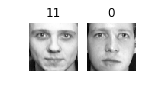

Numer skupienia 96


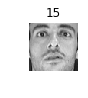

Numer skupienia 97


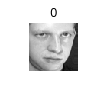

Numer skupienia 98


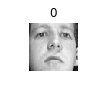

Numer skupienia 99


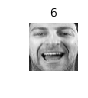

Numer skupienia 100


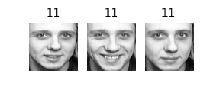

Numer skupienia 101


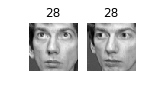

Numer skupienia 102


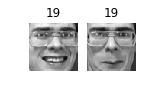

Numer skupienia 103


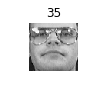

Numer skupienia 104


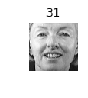

Numer skupienia 105


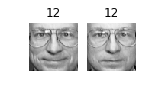

Numer skupienia 106


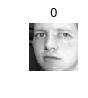

Numer skupienia 107


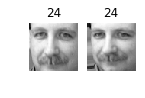

Numer skupienia 108


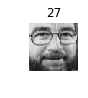

Numer skupienia 109


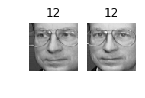

Numer skupienia 110


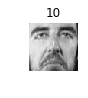

Numer skupienia 111


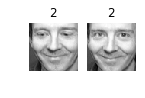

Numer skupienia 112


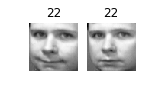

Numer skupienia 113


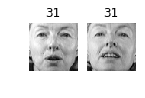

Numer skupienia 114


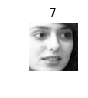

Numer skupienia 115


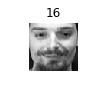

Numer skupienia 116


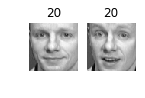

Numer skupienia 117


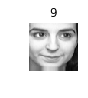

Numer skupienia 118


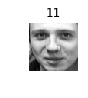

Numer skupienia 119


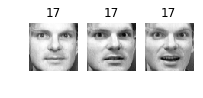

In [197]:
def plot_faces(faces, labels, n_cols=5):
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face.reshape(64, 64), cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Numer skupienia", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster].reshape(-1, 64, 64)
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

Mniej więcej na każde trzy skupienia dwa są przydatne, tzn. zawierają przynajmniej dwa obrazy tej samej osoby. W pozostałych skupieniach pojawia się co najmniej jeden intruz albo składają się tylko z jednego obrazu.

Takie grupowanie obrazów może być zbyt nieprecyzyjne, aby można było używać go bezpośrednio do uczenia modelu (o czym przekonamy się poniżej), ale bardzo przydaje się podczas oznaczania obrazów w nowym zestawie danych: dzięki niemu proces znakowania przebiega znacznie szybciej.

## 11. Analiza skupień jako etap przetwarzania wstępnego w zadaniach klasyfikacji

*Ćwiczenie: Korzystając z zestawu danych Olivetti wytrenuj klasyfikator w przewidywaniu osób widocznych na zdjęciach i zweryfikuj go na zbiorze walidacyjnym.*

In [16]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_pca, y_train)
clf.score(X_valid_pca, y_valid)

0.925

*Ćwiczenie: Następnie użyj algorytmu centroidu jako narzędzia redukowania wymiarowości i wyucz model na tak zmniejszonym zestawie danych.*

In [17]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)
    
clf.score(X_valid_reduced, y_valid)

0.7

Jejku! Ten wynik wcale nie jest lepszy! Sprawdźmy, czy pomoże dostrojenie liczby skupień.

*Ćwiczenie: Wyszukaj liczbę skupień umożliwiającą klasyfikatorowi uzyskanie maksymalnej wydajności: jaką skuteczność jesteś w stanie osiągnąć?*

Moglibyśmy, podobnie jak wcześniej, skorzystać z klasy `GridSearchCV`, ale skoro dysponujemy już zbiorem walidacyjnym, nie potrzebujemy k-krotnego sprawdzianu krzyżowego i wyszukujemy tylko jeden hiperparametr, zatem łatwiej jest zrealizować pętlę własnoręcznie:

In [18]:
from sklearn.pipeline import Pipeline

for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=n_clusters)),
        ("forest_clf", RandomForestClassifier(n_estimators=150, random_state=42))
    ])
    pipeline.fit(X_train_pca, y_train)
    print(n_clusters, pipeline.score(X_valid_pca, y_valid))

5 0.3625
10 0.55
15 0.6125
20 0.6625
25 0.6625
30 0.7
35 0.6875
40 0.7125
45 0.7
50 0.7375
55 0.7375
60 0.75
65 0.725
70 0.7375
75 0.7875
80 0.7125
85 0.725
90 0.775
95 0.7625
100 0.65
105 0.7125
110 0.725
115 0.7625
120 0.7625
125 0.725
130 0.775
135 0.7375
140 0.7375
145 0.725


No cóż, nawet po dostrojeniu liczby skupień nie jesteśmy w stanie przekroczyć dokładności rzędu 80%. Wygląda na to, że odległości do centroidów nie przenoszą tak wielu informacji, jak pierwotne obrazy.

*Ćwiczenie: Co się stanie, jeśli dodasz cechy ze zredukowanego zestawu do pierwotnych cech (również w celu poszukiwania optymalnej liczby skupień)?*

In [19]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_valid_extended = np.c_[X_valid_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

In [20]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_extended, y_train)
clf.score(X_valid_extended, y_valid)

0.8125

Nieco lepiej, ale ciągle gorzej od modelu niewykorzystującego analizy skupień. W tym przypadku skupienia nie są przydatne do bezpośredniego uczenia klasyfikatora (nadal jednak mogą pomóc w oznaczaniu nowych przykładów uczących).

## 12. Model mieszanin gaussowskich na przykładzie zestawu danych Olivetti Faces

*Ćwiczenie: Wyucz model mieszanin gaussowskich na zestawie danych Olivetti. Aby przyspieszyć działanie algorytmu, powinieneś prawdopodobnie zredukować wymiarowość zestawu danych (np. za pomocą analizy PCA, zachowując 99% wariancji).*

In [21]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

*Ćwiczenie: Użyj modelu do wygenerowania nowych twarzy (przy użyciu metody `sample()`) i zwizualizuj je (jeżeli użyłeś analizy głównych składowych, konieczne będzie zastosowanie jej metody `inverse_transform()`).*

In [22]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

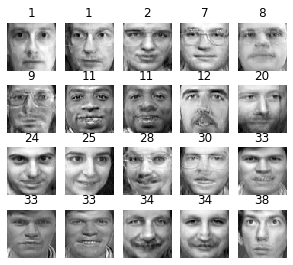

In [23]:
plot_faces(gen_faces, y_gen_faces)

*Ćwiczenie: Spróbuj zmodyfikować niektóre obrazy (np. obróć je, stwórz lustrzane odbicie, przyciemnij) i sprawdź, czy model jest w stanie wykrywać anomalie (porównując wynik metody `score_samples()` dla zwykłych zdjęć i anomalii).*

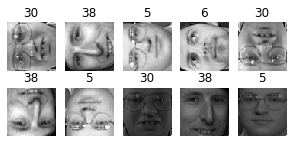

In [24]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
darkened = darkened.reshape(-1, 64*64)
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [25]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [26]:
gm.score_samples(X_bad_faces_pca)

array([-2.43643150e+07, -1.89784991e+07, -3.78112161e+07, -4.98187638e+07,
       -3.20478804e+07, -1.37531031e+07, -2.92373904e+07, -1.05489264e+08,
       -1.19575656e+08, -6.74257782e+07])

Nieprawidłowe twarze są uznawane za wysoce nieprawdopodobne przez model mieszanin gaussowskich. Porównajmy je z wynikami dla niektórych przykładów uczących:

In [27]:
gm.score_samples(X_train_pca[:10])

array([1163.0202095 , 1134.03637995, 1156.32132802, 1170.67602773,
       1141.45404783, 1154.35205193, 1091.32894533, 1111.41149431,
       1096.43048989, 1132.98982741])

## 13. Techniki redukowania wymiarowości w wykrywaniu anomalii 

*Ćwiczenie: Niektóre techniki redukowania wymiarowości mogą zostać także użyte do wykrywania anomalii. Na przykład, przeprowadź redukcję wymiarowości zestawu danych Olivetti za pomocą analizy PCA przy zachowaniu 99% wariancji. Następnie oblicz błąd rekonstrukcji dla każdego obrazu. Teraz skorzystaj ze zmodyfikowanych w poprzednim ćwiczeniu zdjęć i sprawdź ich błąd rekonstrukcji: zwróć uwagę, że jego wartość w ich przypadku jest większa. Jeżeli zwizualizujesz zrekonstruowany obraz, zrozumiesz, dlaczego tak jest: próbuje zrekonstruować normalną twarz.*

Zredukowaliśmy już wcześniej zestaw danych za pomocą analizy PCA:

In [28]:
X_train_pca

array([[ 3.78082848e+00, -1.85478747e+00, -5.14403582e+00, ...,
        -1.35635510e-01, -2.14079559e-01,  6.11926578e-02],
       [ 1.01488495e+01, -1.52754533e+00, -7.66978443e-01, ...,
         1.23931095e-01, -1.35269478e-01, -2.32696794e-02],
       [-1.00152884e+01,  2.87728882e+00, -9.19886231e-01, ...,
         7.26117715e-02, -2.96737882e-03,  1.24885648e-01],
       ...,
       [ 2.47586989e+00,  2.95597243e+00,  1.29985559e+00, ...,
        -2.09138989e-02,  3.48485485e-02, -1.54334918e-01],
       [-3.22031879e+00,  5.34897900e+00,  1.39427102e+00, ...,
         5.75523153e-02, -2.28309885e-01,  1.55576378e-01],
       [-9.22876537e-01, -3.64703059e+00,  2.26088119e+00, ...,
         1.36851206e-01, -6.91276789e-02,  6.26953915e-02]], dtype=float32)

In [29]:
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

In [30]:
reconstruction_errors(pca, X_train).mean()

0.00019205351

In [31]:
reconstruction_errors(pca, X_bad_faces).mean()

0.0047073546

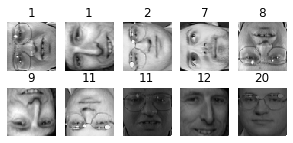

In [32]:
plot_faces(X_bad_faces, y_gen_faces)

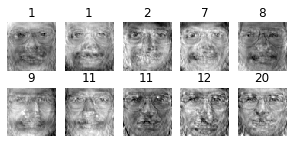

In [33]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_gen_faces)